# Comparison gps/argos, cutoff, drogue/undrogue
For gps+argos, drogued, <25km, <30min

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U
U2 =U**2
#plt.rcParams["axes.edgecolor"] = "w"

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
zarr_dir = zarr_dir+'_ok'

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='00:30:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.251:8787/status,
Dashboard: http://10.148.0.251:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.251:51587,Workers: 0
Dashboard: http://10.148.0.251:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [34]:
cluster.close()

In [4]:
DL, DT = 25e3, 30*60
comb_25 = {'ACC':'drifter_acc_x_25','COR':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_15 = {'ACC':'drifter_acc_x_15','COR':'drifter_coriolis_x_15','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_05 = {'ACC':'drifter_acc_x_05','COR':'drifter_coriolis_x_05','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_no = {'ACC':'drifter_acc_x_0','COR':'drifter_coriolis_x_0','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}

df_alg = dd.read_csv(path_csv(comb_25, 'both', True, DL, DT)).drop(columns = 'drogue_status')
df_15 = dd.read_csv(path_csv(comb_15, 'both', True, DL, DT)).mean().compute()/U2
df_05 = dd.read_csv(path_csv(comb_05, 'both', True, DL, DT)).mean().compute()/U2
df_no = dd.read_csv(path_csv(comb_no, 'both', True, DL, DT)).mean().compute()/U2

dfgps = df_alg.where(df_alg.drifter_type == 'gps').mean().compute()/U2
dfargos = df_alg.where(df_alg.drifter_type == 'argos').mean().compute()/U2

df_und = dd.read_csv(path_csv(comb_25, 'both', False, DL, DT)).mean().compute()/U2

df_alg = df_alg.mean().compute()/U2

In [5]:
def plot_cor_uncor_part(ds1, ds2, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    mt = 0.08
    ds=ds1
    # ACC X
    ax.bar(1.5, ds['B_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['E_acc'], bottom = ds['B_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['ACC']+4*mt, np.round(ds['ACC'],2), horizontalalignment='center')
    rse = np.round(ds['B_acc']/ds['ACC']*100,2)
    ax.text(1.5, ds['B_acc']+mt, f'{rse}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['B_cor'],
           color = c0['cor'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['E_cor'], bottom = ds['B_cor'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['COR']+mt, np.round(ds['COR'],2), horizontalalignment='center')
    rse = np.round(ds['B_cor']/ds['COR']*100,2)
    ax.text(2, ds['B_cor']+mt, f'{rse}%', horizontalalignment='center')

    ds=ds2
    # ACC X
    ax.bar(2.5, ds['B_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['E_acc'], bottom = ds['B_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['ACC']+4*mt, np.round(ds['ACC'],2), horizontalalignment='center')
    rse = np.round(ds['B_acc']/ds['ACC']*100,2)
    ax.text(2.5, ds['B_acc']+mt, f'{rse}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(3, ds['B_cor'],
           color = c0['cor'], width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['E_cor'], bottom = ds['B_cor'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['COR']+mt, np.round(ds['COR'],2), horizontalalignment='center')
    rse = np.round(ds['B_cor']/ds['COR']*100,2)
    ax.text(3, ds['B_cor']+mt, f'{rse}%', horizontalalignment='center')

    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title)
    N = [1.5, 2, 2.5, 3]
    #N=np.arange(1.5,3.5, 0.5) 
    ticks = (r'$d_tu$', r'$-fv$', r'$d_tu$', r'$-fv$')#, r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

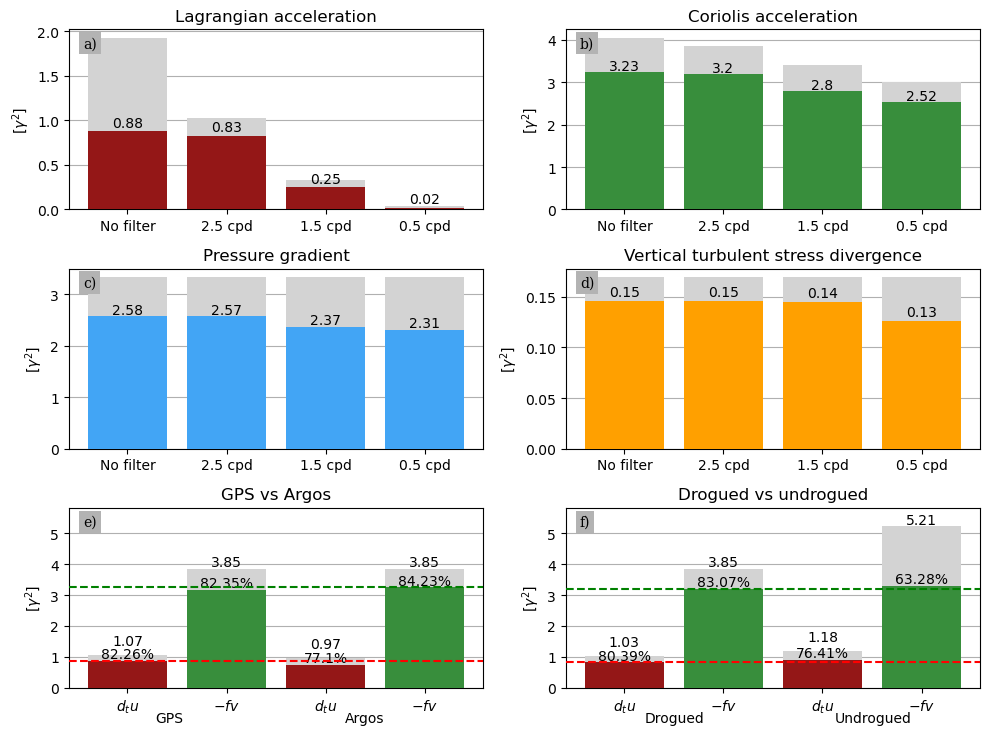

In [6]:
fig, axs = plt.subplots(3,2,figsize=(10,8))
axs =axs.flatten()
xticks = ['No filter', '2.5 cpd', '1.5 cpd', '0.5 cpd']
Title = ['Lagrangian acceleration','Coriolis acceleration', 'Pressure gradient', 'Vertical turbulent stress divergence']

# Different cutoff 
DF = [df_no, df_alg, df_15, df_05]
for i in range(4):
    df_ = DF[i]
    # ACC X
    ax=axs[0]
    ax.bar(i*0.5, df_['B_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, df_['E_acc'], bottom = df_['B_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, df_['B_acc']+0.05, np.round(df_['B_acc'], 2), horizontalalignment='center')
    put_fig_letter(fig, ax, 'a')
    
    # CORIOLIS X
    ax=axs[1]
    ax.bar(i*0.5, df_['B_cor'],
           color = c0['cor'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, df_['E_cor'], bottom = df_['B_cor'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, df_['B_cor']+0.05, str(np.round(df_['B_cor'], 2)), horizontalalignment='center')
    put_fig_letter(fig, ax, 'b')
    
    # GGRAD X
    ax=axs[2]
    ax.bar(i*0.5, df_['B_ggx'],
           color = c0['ggx'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, df_['E_ggx'], bottom = df_['B_ggx'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, df_['B_ggx']+0.05, str(np.round(df_['B_ggx'], 2)), horizontalalignment='center')
    put_fig_letter(fig, ax, 'c')
    
    # Wind X
    ax=axs[3]
    ax.bar(i*0.5, df_['B_wd'],
           color = c0['wd'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, df_['E_wd'], bottom = df_['B_wd'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, df_['B_wd']+0.005, str(np.round(df_['B_wd'],2)), horizontalalignment='center')
    put_fig_letter(fig, ax, 'd')
    
i=0    
for ax in axs[:4]:
    ax.set_xticks([0, 0.5, 1, 1.5], xticks)
    ax.set_title(Title[i])
    i+=1
#axs[2].set_ylim(0, 2.2e-10/U2)


# GPS vs Argos
ax=axs[4]
plot_cor_uncor_part(dfgps,dfargos, ax=ax, title ='GPS vs Argos')
ax.axhline(dfgps.B_acc, ls='--', color='r', zorder=3)
ax.axhline(dfargos.B_cor, ls='--', color='g', zorder=3)
put_fig_letter(fig, ax, 'e')
ax.set_ylim(0, 5.6e-10/U2)


# Drogued vs undrogued
ax=axs[5]
plot_cor_uncor_part(df_alg,df_und, ax=ax, title ='Drogued vs undrogued')
ax.axhline(df_alg.B_acc, ls='--', color='r', zorder=3)
ax.axhline(df_alg.B_cor, ls='--', color='g', zorder=3)
put_fig_letter(fig, ax, 'f')
ax.set_ylim(0, 5.6e-10/U2)

fig.text(0.16, 0.09, 'GPS')
fig.text(0.35, 0.09, 'Argos')
fig.text(0.49 + 0.16, 0.09, 'Drogued')
fig.text(0.49 + 0.35, 0.09, 'Undrogued')
 
for ax in axs:
    ax.grid(axis='y', zorder=0)
    ax.set_ylabel(r'$[\gamma^2]$')

#fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
#ax[0].set_ylabel(r'[m^2/s^4]')
#fig.savefig('../images_all/filter_comp_av.png',bbox_inches='tight',   dpi=300)


In [21]:
(df_no.E_acc - df_alg.E_acc)

0.8435775572132888

In [33]:
df_und.E_cor -df_alg.E_cor

1.262504890735236

_______
## GPS/ARGOS

8.069896967622922e-10
8.296488071207359e-10
8.065626967946749e-10
8.286751005744821e-10


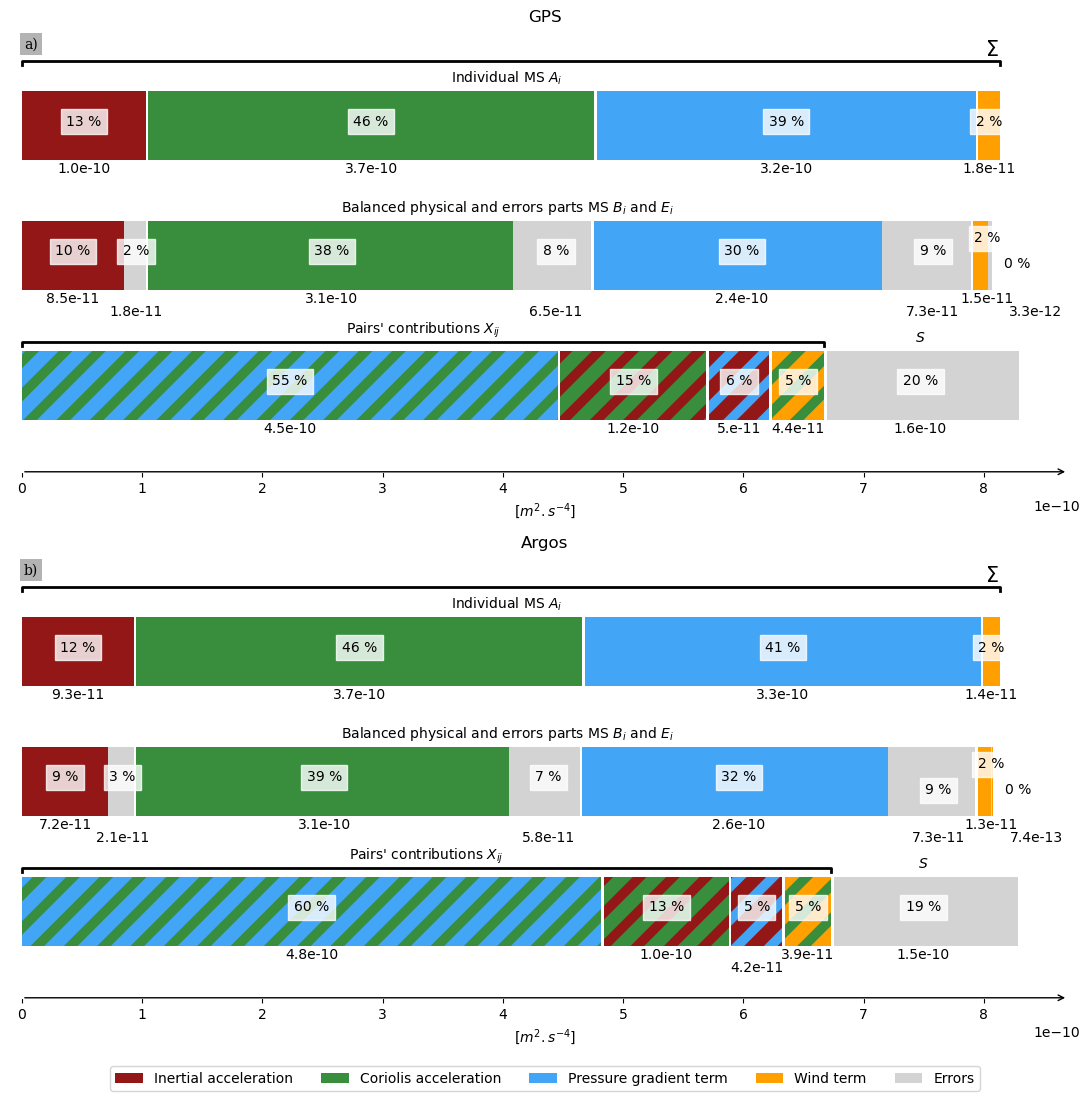

In [27]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dfgps, axs[0], xlim=8.7e-10) 
synthetic_figure(dfargos, axs[1], xlim=8.7e-10, aviso=True) 

axs[0].set_title('GPS')
axs[1].set_title('Argos')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], 'a')
put_fig_letter(fig, axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/synth_samex_alti.png',bbox_inches='tight',   dpi=300)
#fig.savefig('../images_all/synth_samex_alti.jpeg',bbox_inches='tight',   dpi=300)

_______
## Drogued/undrogued

In [28]:
dfdrogued = df_alg.mean()
dfundrogued =pd.read_csv(path(comb_25, 'both', False, DL, DT)).mean()

UnboundLocalError: local variable 'dr_st' referenced before assignment

8.069896967622922e-10
8.296488071207359e-10
8.065626967946749e-10
8.286751005744821e-10


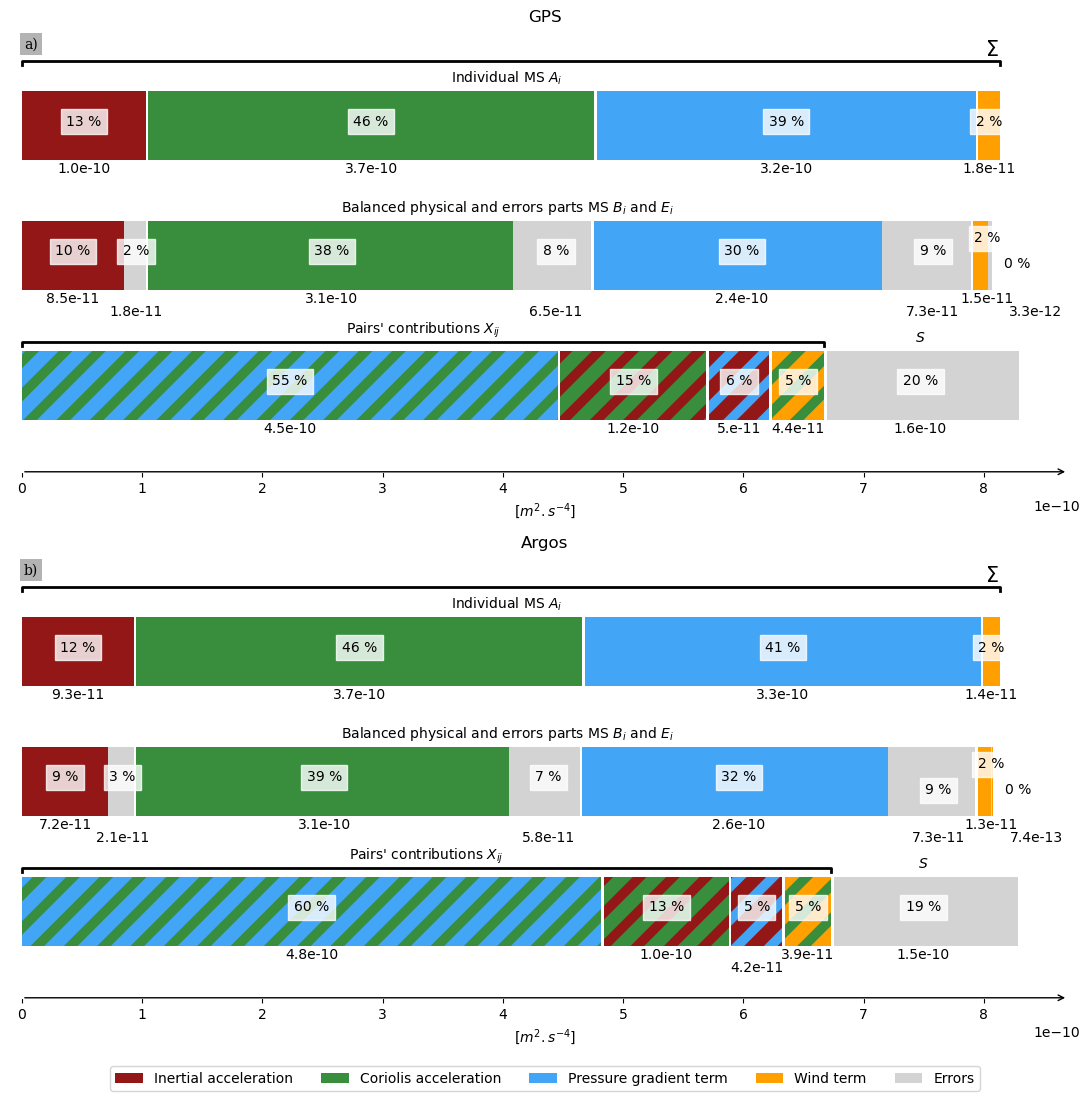

In [27]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )

synthetic_figure(dfdrogued, axs[0], xlim=8.7e-10) 
synthetic_figure(dfundrogued, axs[1], xlim=8.7e-10, aviso=True) 

axs[0].set_title('Drogued')
axs[1].set_title('Undrogued')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], 'a')
put_fig_letter(fig, axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/synth_samex_alti.png',bbox_inches='tight',   dpi=300)
#fig.savefig('../images_all/synth_samex_alti.jpeg',bbox_inches='tight',   dpi=300)

_______
## Cutoff drifters low pass

In [2]:
#cutoff
df25 = df_drogued

comb_25 = {'ACC':'drifter_acc_x_25','COR':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_15 = {'ACC':'drifter_acc_x_15','COR':'drifter_coriolis_x_15','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_05 = {'ACC':'drifter_acc_x_05','COR':'drifter_coriolis_x_05','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
comb_no = {'ACC':'drifter_acc_x_00','COR':'drifter_coriolis_x_00','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}



NameError: name 'select' is not defined

8.068252038712496e-10


NameError: name 'aviso' is not defined

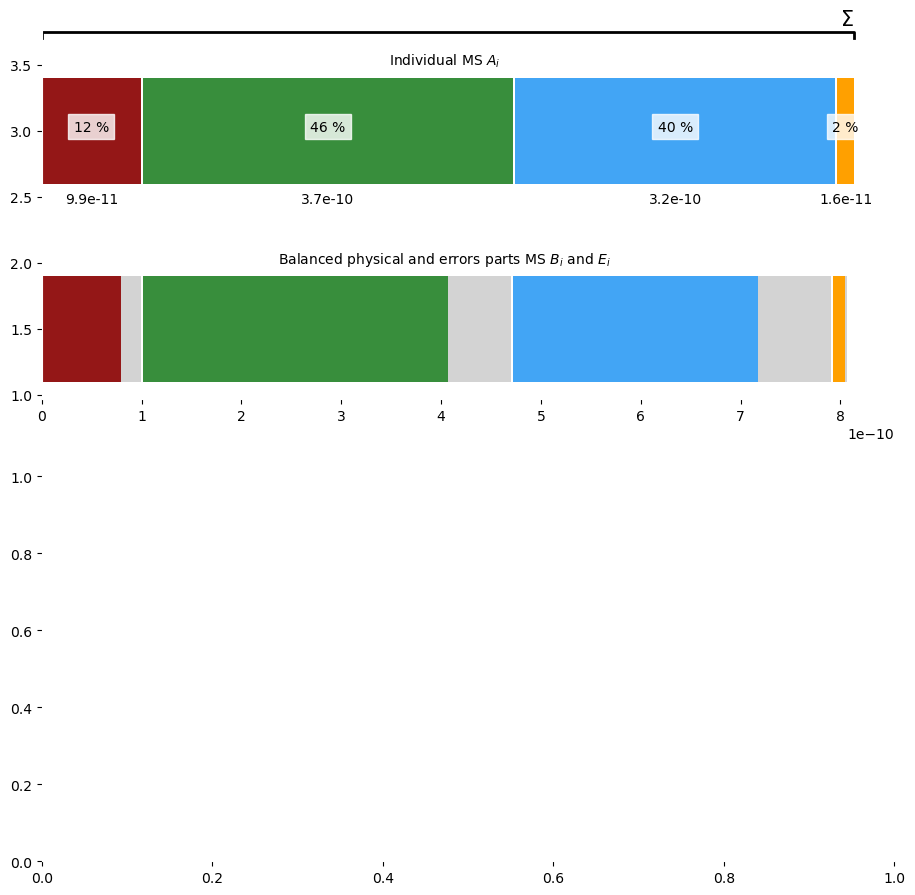

In [14]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(df_alg.mean(), axs[0], xlim=8.7e-10) 
synthetic_figure(df_av_al.mean(), axs[1], xlim=8.7e-10, aviso=True) 

axs[0].set_title('Along-track')
axs[1].set_title('AVISO altimeter')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('../images_all/synth_samex_alti.png',bbox_inches='tight',   dpi=300)
fig.savefig('../images_all/synth_samex_alti.jpeg',bbox_inches='tight',   dpi=300)

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(df_alg.mean(), axs[0], xlim=8.7e-10) 
synthetic_figure(df_av_d.mean(), axs[1], xlim=8.7e-10) 

axs[0].set_title('Along-track')
axs[1].set_title('AVISO drifter')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('../images_all/synth_samex.png',bbox_inches='tight',   dpi=300)
fig.savefig('../images_all/synth_samex.jpeg',bbox_inches='tight',   dpi=300)